In [1]:
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt

EPS = 1e-12

def get_freq(N):
    arr = np.zeros((N,))
    arr[0:int(N-np.floor(N/2))] = np.array(range(0,int(N-np.floor(N/2))))
    arr[int(N-np.floor(N/2)):N] = np.array(range(0,int(np.floor(N/2)))) - np.floor(N/2)
    return arr

In [50]:
def td_tssp_2d_pbc(M, time_steps, a, b, psi0, potential, dt, beta, eps, saving_time):

    x = np.linspace(a, b, M, endpoint=False)
    y = np.linspace(a, b, M, endpoint=False)
    X, Y = np.meshgrid(x, y, sparse=False, indexing="ij")
    t = dt * np.arange(time_steps)
    f = get_freq(M)

    Fx, Fy = np.meshgrid(f, f, sparse=False, indexing="ij")
    F2 = Fx**2 + Fy**2

    psi = np.empty((int(time_steps/saving_time), M, M), dtype=complex)
    psi[0,:] = psi0(X, Y)
    
    V = potential(X, Y) / eps
    zero_pot = (np.abs(V) < EPS).astype(int)
    expV = np.exp(- dt * V / eps)

    p = psi[0,:]

    for i in range(1, time_steps):
        p= _td_tssp_pbc_2d_step(p, dt, beta, eps, x[2]- x[1], x[2]- x[1], b-a, \
                                        V, expV, zero_pot, F2)
        if i%saving_time==0:
            psi[int(i/saving_time),:] = p
    return t, X, Y, psi



def _td_tssp_pbc_2d_step(psi, dt, beta, eps, dx, dy, leng, V, expV, zero_pot, F2):

    abs_psi = np.abs(psi)**2
    p1 = np.empty(psi.shape, dtype=complex)
    p1 = psi * np.where(zero_pot, 1 / np.sqrt(1 + beta*dt * abs_psi), \
                        np.sqrt((V*expV) / (V + beta*(1 - expV)*abs_psi)) )

    p2 = fft.ifft2(fft.fft2(p1) * np.exp(- eps*dt * (np.pi**2/leng**2) * F2))

    abs_p2 = np.abs(p2)**2
    p3 = np.empty(psi.shape, dtype=complex)
    p3 = p2 * np.where(zero_pot, 1 / np.sqrt(1 + beta*dt * abs_p2), \
                        np.sqrt((V*expV) / (V + beta*(1 - expV)*abs_p2)))

    return p3 / np.sqrt(dx*dy * np.sum(np.abs(p3)**2))



def mean_value(f, psi, a, b, M):
    """
    Return the mean value of a function evaluated on a square grid of size
    (b-a)^2 with M^2 points on it w.r.t. the probability density defined by
    the wavefunction psi.
    Parameters
    ----------
    f : function, 2 arguments
        The function of which calculate the mean value. First argument should
        be the x coordinate and the second the y coordinate.
    psi : numpy matrix
        Wave function that defines the probability deensity.
    a : float
        Beginning of the two axes.
    b : float
        Ending of the two axes.
    M : int
        Number of points per axis.
    Raises
    ------
    RuntimeError
        If the size of psi don't match with the gird of paramethes a, b and M.
    Returns
    -------
    scalar
        mean value of the function f.
    """
    delta = np.abs(b-a)/M
    #this is the area element for the case of a square grid. a,b represent the limits of the square in 2D
    dA = delta**2

    x = np.linspace(a, b, M,endpoint=False)
    y = np.linspace(a, b, M,endpoint=False)
    X, Y = np.meshgrid(x, y, sparse=False, indexing="ij")
    

    if psi.shape == X.shape:
        return np.sum(f(X,Y) * np.abs(psi)**2 * dA)
    else:
        raise RuntimeError("Size of psi should match the size of the grid.")



def gradient_2d(psi, x_spacing, y_spacing):
    g = np.empty((2, psi.shape[0], psi.shape[1]), dtype=psi.dtype)
    g[0,:] = (np.roll(psi, 1, axis=0) - psi)/x_spacing
    g[1,:] = (np.roll(psi, 1, axis=1) - psi)/y_spacing
    return g



def energy_gpe(psi, V, beta, x_spacing, y_spacing):
    a = np.abs(psi)
    g = gradient_2d(psi, x_spacing, y_spacing)
    g2 = np.abs(g[0,:])**2 + np.abs(g[1,:])**2
    return x_spacing*y_spacing * np.sum(0.5*g2 + V * a**2 + 0.5*beta * a**4)
def mu_gpe(psi, V, beta, x_spacing, y_spacing):
    a = np.abs(psi)
    g = gradient_2d(psi, x_spacing, y_spacing)
    g2 = np.abs(g[0,:])**2 + np.abs(g[1,:])**2
    return x_spacing*y_spacing * np.sum(0.5*g2 + V * a**2 + beta * a**4)

In [43]:
#M, time_steps, a, b, psi0, potential, dt, beta, eps
M=16*8
N=20000
a=-8
b=8
gx=1
gy=4
saving_time=50
potential=lambda x,y:(gx**2*x**2+gy**2*y**2)/2
psi0= lambda x,y: (gx*gy)**(1/4)*np.exp(-(gx**2*x**2+gy**2*y**2)/2)/np.pi**(1/2)
beta=200.
dt=0.0001
eps=1
x_spacing=(b-a)/M
y_spacing=x_spacing
x_spacing

0.125

In [30]:
psi=td_tssp_2d_pbc(M, N, a, b, psi0, potential, dt, beta, eps,saving_time)

/home/lopetegui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/home/lopetegui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/lopetegui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/home/lopetegui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


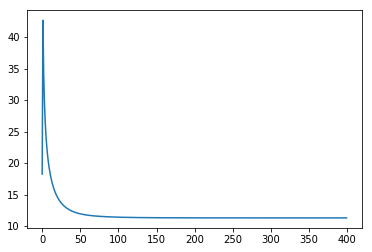

(11.289240827731431,
 2.2891121548429934,
 0.5953068042798357,
 16.513237671149508)

In [51]:
x = np.linspace(a, b, M)
y = np.linspace(a, b, M)
X, Y = np.meshgrid(x, y, sparse=False, indexing="ij")
e=psi0(X,Y)
V = potential(X, Y) / eps
fx= lambda x,y: x
fy= lambda x,y: y
fx2= lambda x,y: x**2
fy2= lambda x,y: y**2

list_en=np.empty(len(psi[3]))
for i in range (len(psi[3])):
    list_en[i]=energy_gpe(psi[3][i], V, beta, x_spacing, y_spacing)
plt.figure()
plt.plot(list_en)
plt.show()
(list_en[-1],np.sqrt(mean_value(fx2,psi[3][-1],a,b,M)-mean_value(fx,psi[3][-1],a,b,M)**2),\
np.sqrt(mean_value(fy2,psi[3][-1],a,b,M)-mean_value(fy,psi[3][-1],a,b,M)**2),mu_gpe(psi[3][-1],V,beta,x_spacing,y_spacing))
